### --- Step 1: Setup and Imports ---


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import hopsworks
import exclude.key
import os

# Hopsworks
HOPSWORKS_API_KEY = exclude.key.HOPSWORKS_API_KEY
FEATURE_GROUP_NAME = "bars_near_london_bridge"
FEATURE_GROUP_VERSION = 3
FEATURE_VIEW_VERSION = 4

# Connect to Hopsworks
project = hopsworks.login(api_key_value=HOPSWORKS_API_KEY)
fs = project.get_feature_store()
mr = project.get_model_registry()


Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/25749
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


### --- Step 2: Load Data from the Feature group ---


In [2]:
# Retrieve feature groups.
fg = fs.get_feature_group(
    name=FEATURE_GROUP_NAME, 
    version=FEATURE_GROUP_VERSION,
)

# Select features for training datasets
df = fg.read()
df.head(5)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.29s) 


,venue_name,venue_address,day,hour,busyness,busyness_numeric,popularity,last_updated
0,Nine Lives,"8 Holyrood St, London SE1 2EL, United Kingdom",Saturday,14,Closed,0,0.438710,2024-06-07 11:16:35.099076+00:00
1,"The Hung Drawn & Quartered, EC3","26-27 Great Tower St, London EC3R 5AQ, United ...",Saturday,7,Closed,0,0.716129,2024-06-07 11:16:35.099076+00:00
2,El Vino London Bridge,"5a More London Pl, London SE1 2BY, United Kingdom",Tuesday,23,Closed,0,0.625806,2024-06-07 11:16:35.099076+00:00
3,"The Bridge Tap, London","32 Borough High St, London SE1 1XU, United Kin...",Tuesday,6,Closed,0,0.858065,2024-06-07 11:16:35.099076+00:00
4,El Vino London Bridge,"5a More London Pl, London SE1 2BY, United Kingdom",Wednesday,15,Average,3,0.625806,2024-06-07 11:16:35.099076+00:00


### --- Step 3: Process the Data ---

In [3]:
# Load transformation functions from the feature store
min_max_scaler = fs.get_transformation_function(name="min_max_scaler")
label_encoder = fs.get_transformation_function(name="label_encoder")

# Define numerical and categorical features
numerical_features = ["hour"]
categorical_features = ["day"]

# Map features to transformation functions
transformation_functions = {}
for feature in numerical_features:
    transformation_functions[feature] = min_max_scaler
for feature in categorical_features:
    transformation_functions[feature] = label_encoder

df.head(5)

,venue_name,venue_address,day,hour,busyness,busyness_numeric,popularity,last_updated
0,Nine Lives,"8 Holyrood St, London SE1 2EL, United Kingdom",Saturday,14,Closed,0,0.438710,2024-06-07 11:16:35.099076+00:00
1,"The Hung Drawn & Quartered, EC3","26-27 Great Tower St, London EC3R 5AQ, United ...",Saturday,7,Closed,0,0.716129,2024-06-07 11:16:35.099076+00:00
2,El Vino London Bridge,"5a More London Pl, London SE1 2BY, United Kingdom",Tuesday,23,Closed,0,0.625806,2024-06-07 11:16:35.099076+00:00
3,"The Bridge Tap, London","32 Borough High St, London SE1 1XU, United Kin...",Tuesday,6,Closed,0,0.858065,2024-06-07 11:16:35.099076+00:00
4,El Vino London Bridge,"5a More London Pl, London SE1 2BY, United Kingdom",Wednesday,15,Average,3,0.625806,2024-06-07 11:16:35.099076+00:00


### --- Step 4: Create the feature view ---

In [4]:
query = fg.select_except(['busyness','venue_address','venue_name','last_updated','busyness'])

feature_view = fs.get_or_create_feature_view(
    name='busyness_feature_view',
    version=FEATURE_VIEW_VERSION,
    query=query,
    labels=["busyness_numeric"],
    transformation_functions=transformation_functions,
)

# if the featureview is already created just retrieve it 
feature_view = fs.get_feature_view(name='busyness_feature_view', version=FEATURE_VIEW_VERSION)


### --- Step 5: Create the training dataset ---

In [6]:
# Split data into training, validation, and test sets
X_train, X_val, X_test, y_train, y_val, y_test = feature_view.train_validation_test_split(
    validation_size=0.2,
    test_size=0.1,
)

X_train, X_val, X_test, y_train, y_val, y_test.head(3)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.75s) 
2024-06-11 19:02:54,476 WARNING: VersionWarning: Incremented version to `7`.



(       day      hour  popularity
 0        0  0.608696    0.438710
 2        1  1.000000    0.625806
 5        2  0.173913    0.764516
 6        3  0.565217    1.000000
 7        2  0.913043    0.651613
 ...    ...       ...         ...
 15114    1  0.173913    0.615385
 15115    2  0.956522    0.763314
 15116    3  0.521739    1.000000
 15117    4  0.000000    0.627219
 15119    3  0.000000    0.917160
 
 [10584 rows x 3 columns],
        day      hour  popularity
 1        0  0.304348    0.716129
 4        4  0.652174    0.625806
 10       4  0.391304    0.651613
 13       4  0.260870    0.912903
 26       5  0.652174    0.812903
 ...    ...       ...         ...
 15094    3  0.869565    0.917160
 15110    5  0.173913    0.668639
 15111    4  0.521739    1.000000
 15113    6  0.173913    0.763314
 15118    0  0.217391    0.642012
 
 [3024 rows x 3 columns],
        day      hour  popularity
 3        1  0.260870    0.858065
 16       1  0.739130    0.858065
 30       6  1.000000    

### --- Step 6: Train and evaluate the model ---

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
{'f1_score': 0.7866210413311863}
2024-06-11 19:03:44,922 WARNING: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown



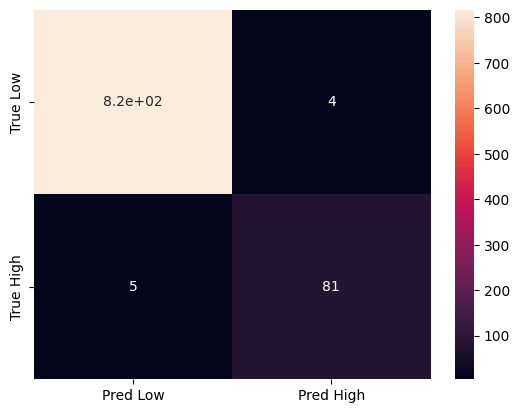

In [7]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create an instance of the XGBClassifier
model = xgb.XGBClassifier()

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1_macro', cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the model with the best parameters
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_train = best_model.predict(X_train)
y_pred_val = best_model.predict(X_val)
y_pred_test = best_model.predict(X_test)

# Compute metrics
metrics = {"f1_score": f1_score(y_test, y_pred_test, average='macro')}
print(metrics)

# Confusion matrix
results = confusion_matrix(y_test, y_pred_test, labels=[0, 1])
df_cm = pd.DataFrame(results, ['True Low', 'True High'], ['Pred Low', 'Pred High'])
cm = sns.heatmap(df_cm, annot=True)
cm.get_figure().show()
fig = cm.get_figure()



### --- Step 7: Save the model ---

In [8]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib

# Create a Schema for the input features
input_schema = Schema(X_train)

# Create a Schema for the output labels
output_schema = Schema(y_train)

# Create a ModelSchema using the input and output schemas
model_schema = ModelSchema(
    input_schema=input_schema, 
    output_schema=output_schema,
)

# Convert the ModelSchema to a dictionary representation
model_schema.to_dict()

{'input_schema': {'columnar_schema': [{'name': 'day', 'type': 'Int32'},
   {'name': 'hour', 'type': 'float64'},
   {'name': 'popularity', 'type': 'float64'}]},
 'output_schema': {'columnar_schema': [{'name': 'busyness_numeric',
    'type': 'int64'}]}}

In [9]:
# Define the directory name for the model registry
model_dir = "busyness_model"

# Check if the directory exists, and create it if not
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

# Save the trained XGBoost model to a file within the model directory
joblib.dump(model, f"{model_dir}/xgboost_busyness.pkl")

# Save the confusion matrix plot to an image file within the model directory
fig.savefig(f"{model_dir}/confusion_matrix.png")


In [10]:
# Get the model registry
mr = project.get_model_registry()

# Create a Python model in the model registry
busyness_model = mr.python.create_model(
    name="xgboost_busyness", 
    metrics=metrics,                     # Specify the metrics used to evaluate the model
    model_schema=model_schema,           # Provide the model schema
    description="Busyness Model",# Add a description for the model
)

# Save the model to the specified model directory
busyness_model.save(model_dir)


Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/16359 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/733 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/394 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/25749/models/xgboost_busyness/3


Model(name: 'xgboost_busyness', version: 3)